In [1]:
import keras
import numpy as np
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt

In [2]:
dir_path = "../../datasets/artifact_features/vgg/"

In [3]:
def load_data(data_range, data_type):
    data_x = []
    data_y = []
    for i in range(*data_range):
        data_x.append(np.load(f"../../datasets/artifact_features/vgg/{data_type}_x_{i}.npy"))
        data_y.append(np.load(f"../../datasets/artifact_features/vgg/{data_type}_y_{i}.npy"))
    data_x = np.concatenate(np.array(data_x), axis=0)
    data_y = np.concatenate(np.array(data_y), axis=0)
    return data_x, data_y

In [4]:
def data_generator(file_paths, batch_size):
    for file_path in file_paths:
        data = np.load(dir_path+file_path)
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]

In [5]:
def create_train_dataset(data_range, batch_size):
    train_x_files = [f"train_x_{i}.npy" for i in range(*data_range)]
    train_y_files = [f"train_y_{i}.npy" for i in range(*data_range)]
    
    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_x_files, batch_size),
        output_signature=tf.TensorSpec(shape=(None, 6, 6, 512), dtype=tf.float32)
    )
    train_labels_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_y_files, batch_size),
        output_signature=tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
    train = tf.data.Dataset.zip((train_dataset, train_labels_dataset))
    train = train.shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
    
    return train

In [6]:
valid_x_files = ['valid_x_1.npy', 'valid_x_2.npy']
valid_y_files = ['valid_y_1.npy', 'valid_y_2.npy']

In [7]:
batch_size = 256

In [8]:
valid_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(valid_x_files, batch_size),
    output_signature=tf.TensorSpec(shape=(None, 6, 6, 512), dtype=tf.float32)  # Adjust shape according to your data
)

valid_labels_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(valid_y_files, batch_size),
    output_signature=tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
)

In [9]:
valid = tf.data.Dataset.zip((valid_dataset, valid_labels_dataset))
valid = valid.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
def create_dense():
    l2 = tf.keras.regularizers.l2(0.0005)
    
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(6,6,512)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(4096, activation='elu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2048, activation='elu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2048, activation='elu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=adam,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    model.summary()
    return model

In [17]:
dense_1 = create_dense()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_6 (Dropout)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              75501568  
                                                                 
 dropout_7 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 2048)             

In [12]:
def lr_schedule(epoch, lr):
    if 5 > CUR_SUBSET > 0 and epoch % 5 == 0:
        return lr*2/3
    elif CUR_SUBSET > 4 and epoch % 3 == 0:
        return lr*2/3
    else:
        return lr

In [13]:
history = []

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5,
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=5e-6)

scheduler = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule, verbose=1)

for i in range(9):
    CUR_SUBSET = i
    train = create_train_dataset((i*5, i*5+5), batch_size)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f"./saved_models/checkpoints/0005l2_allsamples_{CUR_SUBSET+9}.h5", save_best_only=True, monitor='val_accuracy', mode='max')
    if i > 4:
        history.append(dense_1.fit(train, validation_data=valid, epochs=3, callbacks=[scheduler, checkpoint]).history)
    else:
        history.append(dense_1.fit(train, validation_data=valid, epochs=5, callbacks=[scheduler, checkpoint]).history)    


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/5
640/640 [==============================] - 60s 77ms/step - loss: 10.4633 - accuracy: 0.5948 - precision: 0.5818 - recall: 0.5860 - val_loss: 9.4573 - val_accuracy: 0.6312 - val_precision: 0.8268 - val_recall: 0.3044 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/5
640/640 [==============================] - 62s 78ms/step - loss: 9.2236 - accuracy: 0.6439 - precision: 0.6328 - recall: 0.6339 - val_loss: 8.8470 - val_accuracy: 0.6360 - val_precision: 0.8406 - val_recall: 0.3091 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/5
640/640 [==============================] - 63s 80ms/step - loss: 8.5725 - accuracy: 0.6712 - precision: 0.6569 - recall: 0.6748 - val_loss: 8.1975 - val_accuracy: 0.6685 - val_precision: 0.8290 - val_recall: 0.4000 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler s

In [14]:
def plot(history: list):
    merged = {}

    for key in history[0].keys():
        merged[key] = []
        
    for d in history:
        for key in d.keys():
            if any(x in key for x in ["accuracy", "loss", "val_accuracy", "val_loss"]):
                merged[key].extend(d[key])
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    ax[0].plot(merged["loss"], "r.", label="Loss")
    ax[0].plot(merged["val_loss"], "b", label="Val_loss")
    
    ax[1].plot(merged["accuracy"], "g.", label="Accuracy")
    ax[1].plot(merged["val_accuracy"], "y", label="Val_accuracy")
    fig.legend()
    plt.show()

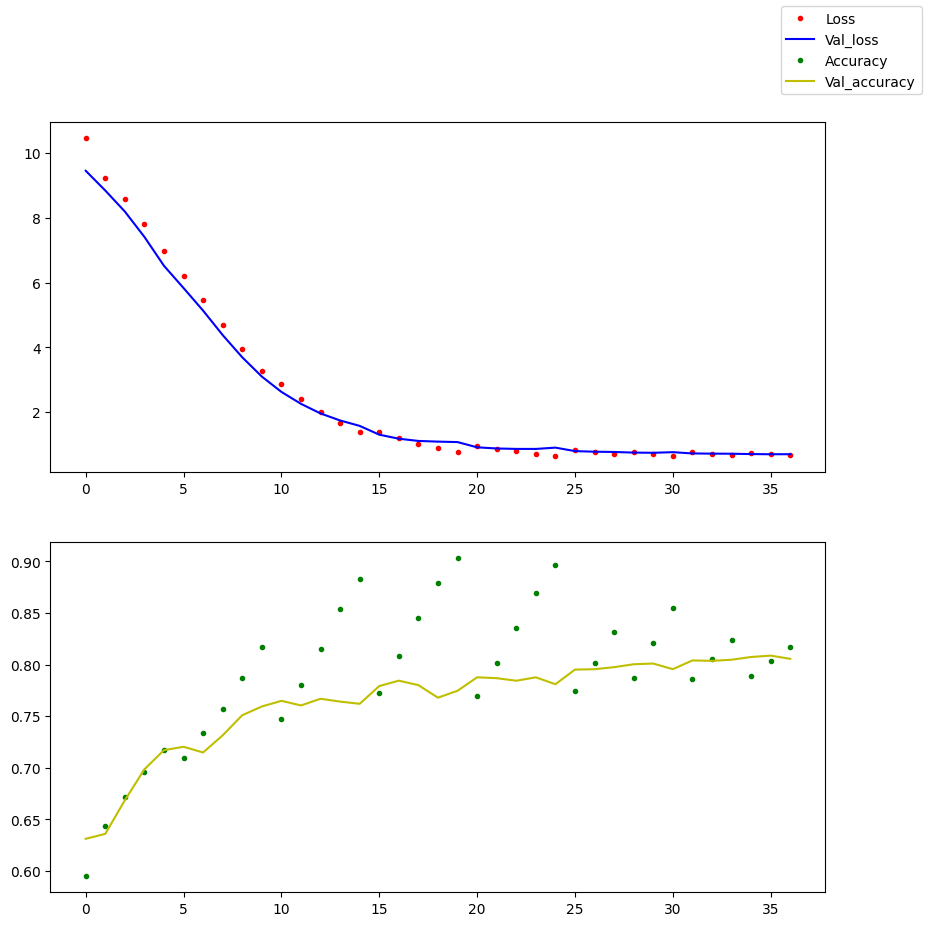

In [15]:
plot(history)